# Model building

https://www.kaggle.com/vadbeg/pytorch-nn-with-embeddings-and-catboost/notebook#PyTorch

mostly based off this example, plus parts of code form tutorial 5 lab 3

In [1]:
# import load_data function from 
%load_ext autoreload
%autoreload 2

# fix system path
import sys
sys.path.append("/home/jovyan/work")

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministick = True
    torch.backends.cudnn.benchmark = False 
    
set_seed(27)

In [4]:
from src.data.sets import load_sets

X_train, y_train, X_val, y_val, X_test, y_test = load_sets()

In [5]:
X_test.shape

(317320, 5)

In [6]:
X_train.shape

(951959, 5)

In [7]:
X_val.shape

(317320, 5)

In [8]:
X_train

array([[ 1.89700000e+03,  3.78951241e-01,  1.06859912e+00,
         1.84150005e+00,  9.66077605e-01],
       [ 4.91800000e+03, -3.20469239e+00, -2.17768163e+00,
        -3.57227099e-01, -4.00106932e-01],
       [ 1.70100000e+03, -3.37777485e-01,  2.57028931e-01,
        -3.57227099e-01, -4.00106932e-01],
       ...,
       [ 4.59800000e+03,  1.09567997e+00,  2.57028931e-01,
        -3.57227099e-01,  2.82985337e-01],
       [ 3.18900000e+03,  3.78951241e-01,  1.06859912e+00,
         3.75681950e-01,  2.82985337e-01],
       [ 9.70000000e+01,  3.78951241e-01, -2.17768163e+00,
        -3.57227099e-01,  2.82985337e-01]])

In [9]:
# need to convert to tensors
from src.models.pytorch import EmbeddingDataset

In [10]:
train_dataset = EmbeddingDataset(X_train, 
                                      targets=y_train,
                                      cat_cols_idx=[0],
                                      cont_cols_idx=[1,2,3,4])

val_dataset = EmbeddingDataset(X_val, 
                                      targets=y_val,
                                      cat_cols_idx=[0],
                                      cont_cols_idx=[1,2,3,4])


test_dataset = EmbeddingDataset(X_test,
                                     cat_cols_idx=[0],
                                     cont_cols_idx=[1,2,3,4],
                                     is_train=False)

In [11]:
print(f'First element of train_dataset: {train_dataset[1]}',
      f'First element of val_dataset: {val_dataset[1]}',
      f'First element of test_dataset: {test_dataset[1]}',sep='\n')

First element of train_dataset: {'data': [tensor([4918.]), tensor([-3.2047, -2.1777, -0.3572, -0.4001])], 'target': tensor(13)}
First element of val_dataset: {'data': [tensor([163.]), tensor([-1.0545, -0.5545, -1.0901, -1.0832])], 'target': tensor(31)}
First element of test_dataset: {'data': [tensor([701.]), tensor([ 0.3790,  0.2570,  0.3757, -0.4001])]}


In [12]:
# embedding example
class ClassificationEmbdNN(torch.nn.Module):
    
    def __init__(self, emb_dims, no_of_cont=None):
        super(ClassificationEmbdNN, self).__init__()
        
        self.emb_layers = torch.nn.ModuleList([torch.nn.Embedding(x, y)
                                               for x, y in emb_dims])
        
        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.emb_dropout = torch.nn.Dropout(0.2)
        
        self.no_of_cont = 0
        if no_of_cont:
            self.no_of_cont = no_of_cont
            self.bn_cont = torch.nn.BatchNorm1d(no_of_cont)
        
        self.fc1 = torch.nn.Linear(in_features=self.no_of_embs + self.no_of_cont, 
                                   out_features=208)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.bn1 = torch.nn.BatchNorm1d(208)
        self.act1 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(in_features=208, 
                                   out_features=208)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(208)
        self.act2 = torch.nn.ReLU()
        
#         self.fc3 = torch.nn.Linear(in_features=256, 
#                                    out_features=64)
#         self.dropout3 = torch.nn.Dropout(0.2)
#         self.bn3 = torch.nn.BatchNorm1d(64)
#         self.act3 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(in_features=208, 
                                   out_features=104)
        self.act3 = torch.nn.Softmax()
        
    def forward(self, x_cat, x_cont=None):
        if self.no_of_embs != 0:
            x = [emb_layer(x_cat[:, i])
                 for i, emb_layer in enumerate(self.emb_layers)]
        
            x = torch.cat(x, 1)
            x = self.emb_dropout(x)
            
        if self.no_of_cont != 0:
            x_cont = self.bn_cont(x_cont)
            
            if self.no_of_embs != 0:
                x = torch.cat([x, x_cont], 1)
            else:
                x = x_cont
        
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
#         x = self.fc3(x)
#         x = self.dropout3(x)
#         x = self.bn3(x)
#         x = self.act3(x)
        
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [13]:
model = ClassificationEmbdNN(emb_dims=[[5742, 252]], 
                             no_of_cont=4)

In [14]:
from src.models.pytorch import get_device

device = get_device()
model.to(device)

ClassificationEmbdNN(
  (emb_layers): ModuleList(
    (0): Embedding(5742, 252)
  )
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=208, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (fc2): Linear(in_features=208, out_features=208, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (fc3): Linear(in_features=208, out_features=104, bias=True)
  (act3): Softmax(dim=None)
)

In [15]:
model

ClassificationEmbdNN(
  (emb_layers): ModuleList(
    (0): Embedding(5742, 252)
  )
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=208, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (fc2): Linear(in_features=208, out_features=208, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (fc3): Linear(in_features=208, out_features=104, bias=True)
  (act3): Softmax(dim=None)
)

In [16]:
criterion = torch.nn.CrossEntropyLoss()

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [18]:
BATCH_SIZE = 300
N_EPOCHS = 10

In [66]:
# from torch.utils.data.sampler import SubsetRandomSampler

# train_sampler = SubsetRandomSampler(X_train)

# valid_sampler = SubsetRandomSampler(X_val)


In [19]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

valid_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE)

In [20]:
batches = iter(train_loader)

In [21]:
next(batches)

{'data': [tensor([[4950.],
          [ 701.],
          [4838.],
          [3623.],
          [4743.],
          [1212.],
          [4538.],
          [5607.],
          [5669.],
          [4950.],
          [4950.],
          [2368.],
          [3884.],
          [4717.],
          [5115.],
          [4581.],
          [ 819.],
          [2112.],
          [3775.],
          [4489.],
          [4838.],
          [5472.],
          [1278.],
          [3260.],
          [4743.],
          [5003.],
          [ 528.],
          [ 177.],
          [5597.],
          [1182.],
          [1238.],
          [2909.],
          [ 375.],
          [4074.],
          [1334.],
          [1879.],
          [ 701.],
          [ 235.],
          [1251.],
          [5392.],
          [1963.],
          [ 482.],
          [ 701.],
          [5078.],
          [ 235.],
          [ 148.],
          [4489.],
          [3438.],
          [ 144.],
          [3431.],
          [5115.],
          [1168.],
    

In [22]:
next(batches)

{'data': [tensor([[3791.],
          [1341.],
          [3799.],
          [4473.],
          [3747.],
          [ 413.],
          [3935.],
          [ 384.],
          [ 701.],
          [2318.],
          [ 291.],
          [1282.],
          [1450.],
          [2239.],
          [4794.],
          [3033.],
          [ 177.],
          [1238.],
          [5377.],
          [ 151.],
          [1342.],
          [2262.],
          [ 412.],
          [5531.],
          [5607.],
          [ 413.],
          [ 701.],
          [2601.],
          [2262.],
          [4667.],
          [5405.],
          [  97.],
          [1963.],
          [ 154.],
          [4963.],
          [4843.],
          [4950.],
          [2880.],
          [2884.],
          [4843.],
          [2262.],
          [3841.],
          [1032.],
          [  57.],
          [1282.],
          [5078.],
          [ 911.],
          [3189.],
          [4228.],
          [ 173.],
          [3014.],
          [3802.],
    

In [33]:
next(iter(valid_loader))

{'data': [tensor([[4884.],
          [ 163.],
          [ 217.],
          [ 163.],
          [2262.],
          [5378.],
          [4280.],
          [ 413.],
          [5003.],
          [2461.],
          [2461.],
          [2316.],
          [3841.],
          [5066.],
          [4453.],
          [2461.],
          [3341.],
          [ 151.],
          [4830.],
          [2239.],
          [5014.],
          [3237.],
          [2514.],
          [5378.],
          [5014.],
          [5448.],
          [3189.],
          [5242.],
          [2523.],
          [1605.],
          [2601.],
          [5364.],
          [ 163.],
          [5078.],
          [ 224.],
          [2689.],
          [4132.],
          [ 375.],
          [ 360.],
          [3888.],
          [2239.],
          [5392.],
          [1334.],
          [4598.],
          [1951.],
          [4680.],
          [1306.],
          [5330.],
          [ 154.],
          [3804.],
          [4950.],
          [ 386.],
    

In [23]:
print(valid_loader.sampler)

In [24]:
from tqdm import tqdm_notebook as tqdm

In [25]:
def train_network(model, train_loader, valid_loader,
                  loss_func, optimizer, n_epochs=20,
                  saved_model='model.pt'):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_losses = list()
    valid_losses = list()
    
    valid_loss_min = np.Inf
    
    for epoch in range(n_epochs):
        
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            output = model(batch['data'][0].to(device, 
                                               dtype=torch.long),
                           batch['data'][1].to(device, 
                                               dtype=torch.float))
            
            loss = loss_func(output, batch['target'].to(device, 
                                                        dtype=torch.long))
            
            train_loss += loss.item() * batch['data'][0].size(0)
            
            loss.backward()
            optimizer.step()
            
            # Calculate global accuracy
            train_acc += (output.argmax(1) == batch['target']).sum().item()

            
    

        model.eval()
        for batch in tqdm(valid_loader):
            output = model(batch['data'][0].to(device, 
                                               dtype=torch.long),
                           batch['data'][1].to(device, 
                                               dtype=torch.float))
            
            
            loss = loss_func(output, batch['target'].to(device, 
                                                        dtype=torch.long))
            
            valid_loss += loss.item() * batch['data'][0].size(0)  #!!!
            # Calculate global accuracy
            valid_acc += (output.argmax(1) == batch['target']).sum().item()
        
        train_loss = np.sqrt(train_loss / len(train_loader))
        valid_loss = np.sqrt(valid_loss / len(valid_loader))

        train_acc = train_acc / len(train_loader)
        valid_acc = valid_acc / len(valid_loader)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {}. Training loss: {:.8f}. Validation loss: {:.8f}'
              .format(epoch, train_loss, valid_loss))
        print('Training Accuracy: {:.8f}. Validation Accuracy: {:.8f}'
              .format(train_acc, valid_acc))
        
        if valid_loss < valid_loss_min:  # let's save the best weights to use them in prediction
            print('Validation loss decreased ({:.8f} --> {:.8f}). Saving model...'
                  .format(valid_loss_min, valid_loss))
            
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    
    return train_losses, valid_losses

In [28]:
train_losses, valid_losses = train_network(model=model, 
                                           train_loader=train_loader, 
                                           valid_loader=valid_loader, 
                                           loss_func=criterion, 
                                           optimizer=optimizer,
                                           n_epochs=5, 
                                           saved_model='../models/embed_3layers.pt')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 0. Training loss: 37.07604849. Validation loss: 37.09084730
Training Accuracy: 23.24417139. Validation Accuracy: 22.14744802
Validation loss decreased (inf --> 37.09084730). Saving model...



Epoch: 1. Training loss: 37.10066659. Validation loss: 37.09084730
Training Accuracy: 21.41682420. Validation Accuracy: 22.14744802



Epoch: 2. Training loss: 37.08895869. Validation loss: 37.09084730
Training Accuracy: 22.28607435. Validation Accuracy: 22.14744802



Epoch: 3. Training loss: 37.08897145. Validation loss: 37.09084730
Training Accuracy: 22.28512917. Validation Accuracy: 22.14744802



Epoch: 4. Training loss: 37.08890339. Validation loss: 37.09084730
Training Accuracy: 22.29017013. Validation Accuracy: 22.14744802


In [29]:
train_losses

[37.076048493787276,
 37.10066659011123,
 37.088958694775506,
 37.088971449476695,
 37.08890338526]

In [30]:
valid_losses

[37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
train_losses, valid_losses = train_network(model=model, 
                                           train_loader=train_loader, 
                                           valid_loader=valid_loader, 
                                           loss_func=criterion, 
                                           optimizer=optimizer,
                                           n_epochs=20, 
                                           saved_model='../models/embed_3layers3.pt')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 0. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448
Validation loss decreased (inf --> 37.090847). Saving model...



Epoch: 1. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 2. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 3. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 4. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 5. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 6. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 7. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 8. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 9. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 10. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 11. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 12. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 13. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 14. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 15. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 16. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 17. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 18. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448



Epoch: 19. Training loss: 37.088971. Validation loss: 37.090847
Training Accuracy: 22.285129. Validation Accuracy: 22.147448


In [48]:
train_losses

[37.08897145257539,
 37.08897144565699,
 37.088971451848316,
 37.08897145833736,
 37.08897145653485,
 37.08897143048752,
 37.088971442420565,
 37.088971460239115,
 37.088971455319665,
 37.088971462784905,
 37.088971445598254,
 37.088971451360216,
 37.08897147399492,
 37.088971460648224,
 37.088971445871664,
 37.08897143452191,
 37.088971458825455,
 37.08897144973188,
 37.088971462491244,
 37.088971465529184]

In [49]:
valid_losses

[37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025,
 37.090847304752025]

#### train_loader.sampler.indices doesn't work

Therefore need to divide by the batch size manually, or find alternative

In [31]:
print('Training loss: {:.3f}%'.format(np.mean(train_losses)))
print('Validation loss: {:.3f}%'.format(np.mean(valid_losses)))

Training loss: 37.089%
Validation loss: 37.091%


# Predict with test set

In [32]:
def predict(data_loader, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    
    with torch.no_grad():
        predictions = None
        
        for i, batch in enumerate(tqdm(data_loader)):   
            
            output = model(batch['data'][0].to(device, 
                                               dtype=torch.long), 
                           batch['data'][1].to(device, 
                                               dtype=torch.float)).cpu().numpy()
            
            if i == 0:
                predictions = output
                
            else: 
                
                predictions = np.vstack((predictions, output))
                
    return predictions

In [33]:
model.load_state_dict(torch.load('../models/embed_3layers.pt'))

test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE)

nn_predictions = predict(test_loader, model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
np.set_printoptions(threshold = 100)
nn_predictions.argmax(1)

array([12, 12, 12, ..., 12, 12, 12])

In [35]:
test_acc = (nn_predictions.argmax(1) == y_test).sum().item()

In [36]:
test_acc/317320

0.07380247069204589

In [37]:
twelves = np.where(y_test == 12)
print(sum(list(twelves)))

[     8      9     53 ... 317281 317303 317313]


In [42]:
from sklearn.metrics import roc_auc_score, classification_report

In [ ]:
# compute other metrics
roc_auc_score(y_test,nn_predictions, multi_class='ovr', average='macro')

In [38]:
print(y_test)
print(nn_predictions.argmax(1))

[ 83 102  11 ...  43   9  14]
[12 12 12 ... 12 12 12]


In [39]:
def convert_cr_to_dataframe(report_dict:dict) -> pd.DataFrame:
    """
    Converts the dictionary format of the Classification Report (CR) to a
    dataframe for easy of sorting
    :param report_dict: The dictionary returned by 
    sklearn.metrics.classification_report.
    :return: Returns a dataframe of the same information.
    """
    beer_style = list(report_dict.keys())
    beer_style.remove('accuracy')
    beer_style.remove('macro avg')
    beer_style.remove('weighted avg')
    precision = []
    recall = []
    f1 = []
    support = []
    for key, value in report_dict.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg']:
            precision.append(value['precision'])
            recall.append(value['recall'])
            f1.append(value['f1-score'])
            support.append(value['support'])
    result = pd.DataFrame({'beer_style': beer_style,
                           'precision': precision,
                           'recall': recall,
                           'f1': f1,
                           'support': support})
    return result

In [40]:
from joblib import load

style_encoder = load('../models/style_encoder.joblib')

In [44]:
pd.options.display.max_rows = 150
report_dict = classification_report(style_encoder.inverse_transform(y_test),
                                    style_encoder.inverse_transform(nn_predictions.argmax(1)),
                                    output_dict=True)
report_df = convert_cr_to_dataframe(report_dict)
print(report_df)
#classification_report(y_test, nn_predictions.argmax(1))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              beer_style  precision  recall       f1  support
0                                Altbier   0.000000     0.0  0.00000     1574
1                 American Adjunct Lager   0.000000     0.0  0.00000     6047
2               American Amber / Red Ale   0.000000     0.0  0.00000     9298
3             American Amber / Red Lager   0.000000     0.0  0.00000     1851
4                    American Barleywine   0.000000     0.0  0.00000     5439
5                     American Black Ale   0.000000     0.0  0.00000     2336
6                    American Blonde Ale   0.000000     0.0  0.00000     2579
7                     American Brown Ale   0.000000     0.0  0.00000     5026
8                American Dark Wheat Ale   0.000000     0.0  0.00000      284
9         American Double / Imperial IPA   0.000000     0.0  0.00000    17309
10    American Double / Imperial Pilsner   0.000000     0.0  0.00000     1150
11      American Double / Imperial Stout   0.000000     0.0  0.0

In [45]:
report_df.to_csv('../data/processed/class_report_badmodel.csv')

In [127]:
#torch.save(model, "../models/model.pt")

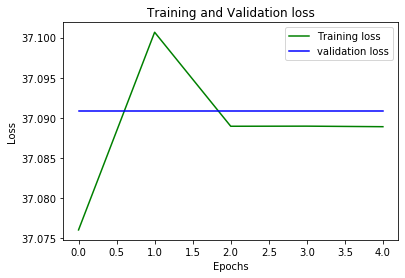

In [54]:
import matplotlib.pyplot as plt


epochs = range(1,5)
plt.plot(train_losses, 'g', label='Training loss')
plt.plot(valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
train_losses

[37.076048493787276,
 37.10066659011123,
 37.088958694775506,
 37.088971449476695,
 37.08890338526]

In [55]:
name_encoder = load('../models/name_encoder.joblib')

In [57]:
le_name_mapping = dict(zip(name_encoder.classes_, name_encoder.inverse_transform(name_encoder.classes_)))
print(pd.DataFrame.from_dict(le_name_mapping, orient='index',columns=['ID']))

ValueError: y contains previously unseen labels: ["'t Hofbrouwerijke" '(512) Brewing Company' '10 Barrel Brewing Co.' ...
 'Ølfabrikken' 'Ørbæk Bryggeri' 'Łódzkie Browary S.A.']